In [1]:
import os

import torch
import torch.nn as nn

import pickle as pk

from model_definitions import AuTransformer

from data_handling import SequenceDataset
from torch.utils.data import DataLoader

MODEL_NAME = "trained_model.pk"
DATA_PATH = "../data/problem_1_train_dfa_only_accepting.dat"

# Model and data definitions

# Algorithm start

In [2]:
model = torch.load(MODEL_NAME)
for param in model.parameters():
    param.requires_grad = False
model.eval()

AuTransformer(
  (pos_encoding): PositionalEncoding()
  (input_embedding): Embedding(7, 3)
  (output_fnn): Linear(in_features=3, out_features=7, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax_output): Softmax(dim=-1)
  (attention_output_layer): Identity()
  (attention_weight_layer): Identity()
)

In [3]:
dataset = SequenceDataset(DATA_PATH, maxlen=10, max_sequences=None)
dataset.initialize()
dataset.encode_sequences()

Alphabet size:  4
Sequences loaded. Some examples: 
[['a', 'b'], ['a', 'b'], ['c', 'd', 'a', 'b']]
The symbol dictionary: {'a': 0, 'b': 1, 'c': 2, 'd': 3}


In [4]:
test_idx = 200
ordinal_seq, ordinal_seq_sr, one_hot_seq, one_hot_seq_sr, label, sequence_length = dataset[test_idx]
res = model(torch.unsqueeze(ordinal_seq, -1), torch.unsqueeze(ordinal_seq_sr, -1))

In [5]:
list(res.size()), list(ordinal_seq_sr.size())

([12, 1, 7], [12])

In [6]:
torch.argmax(torch.squeeze(res), dim=1), ordinal_seq_sr

(tensor([2, 3, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6]),
 tensor([2, 3, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6]))

# Inspect the internal representations of the model

In [7]:
# Tutorial on hooks: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/

activation = {}
def getActivation(name):
    global activation
    # the hook signature
    def hook(model, input, output):
        global activation
        activation[name] = output.detach()
    return hook

#model.input_embedding.register_forward_hook(getActivation("embedding"))
#model.encoder.register_forward_hook(getActivation("encoder"))
model.attention_output_layer.register_forward_hook(getActivation("attention_output"))
model.attention_weight_layer.register_forward_hook(getActivation("attention_weights"))

model.src_embedding_output_layer.register_forward_hook(getActivation("src_embedding_out"))
model.tgt_embedding_output_layer.register_forward_hook(getActivation("tgt_embedding_out"))

AttributeError: 'AuTransformer' object has no attribute 'src_embedding_output_layer'

In [11]:
test_idx = 1001
ordinal_seq, ordinal_seq_sr, one_hot_seq, one_hot_seq_sr, label, sequence_length = dataset[test_idx]
with torch.no_grad():
    res = model(torch.unsqueeze(ordinal_seq, -1), torch.unsqueeze(ordinal_seq_sr, -1))

#model(torch.unsqueeze(ordinal_seq, -1), torch.unsqueeze(ordinal_seq_sr, -1))
activation, ordinal_seq

({'attention_output': tensor([[[-0.5872, -0.8254,  0.4999]],
  
          [[-0.0308, -0.1508,  0.0360]],
  
          [[-0.1481, -0.3423,  0.1846]],
  
          [[ 0.2219,  0.2564, -0.2071]],
  
          [[ 0.1906,  0.2953, -0.2143]],
  
          [[ 0.3691,  0.7152, -0.4773]],
  
          [[ 0.2627,  0.4693, -0.3270]],
  
          [[ 0.3384,  0.6990, -0.4671]],
  
          [[ 0.1469,  0.4442, -0.2763]],
  
          [[ 0.4216,  0.7874, -0.5419]],
  
          [[ 0.3303,  0.5944, -0.4176]],
  
          [[ 0.4029,  0.7808, -0.5303]]]),
  'attention_weights': tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.3800, 0.6200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.3346, 0.3043, 0.3611, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.1763, 0.4644, 0.0810, 0.2783, 0.0000, 0.0000, 0.0000, 0

In [12]:
for name, t in activation.items():
    print("{}: {}".format(name, list(t.size())))

src_embedding_out: [12, 1, 3]
attention_output: [12, 1, 3]
attention_weights: [1, 12, 12]
tgt_embedding_out: [12, 1, 3]


In [13]:
attention_weights = torch.squeeze(activation["attention_weights"])
list(attention_weights.size()), attention_weights

([12, 12],
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.5616, 0.4384, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.3656, 0.4669, 0.1676, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.1493, 0.2616, 0.4614, 0.1277, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0453, 0.2166, 0.6881, 0.0295, 0.0206, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0976, 0.2455, 0.3420, 0.0771, 0.0717, 0.1661, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0356, 0.1874, 0.6249, 0.0225, 0.0161, 0.0925, 0.0209, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0699, 0.1932, 0.2832, 0.0536, 0.0511, 0.1289, 0.0627, 0.1575, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0225, 0.1525, 0.5814, 0.0131, 0.0100, 0.0

# Cluster the representations and express sequences in terms of their clusters. Can you see something?

In [14]:
import numpy as np

def get_weighted_embedding_vector(embeddings, attn_weights, scale=True, scaling_factor: int=1):
    res = np.zeros((1, embeddings.shape[1]))
    for i in range(len(attn_weights)):
        res += attn_weights[i] * embeddings[i, :]
    if scale:
        res /= scaling_factor
    return res

In [15]:
#weights = None
src_embeddings = None
weighted_embeddings = None
symbols = None
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for j, (test_string_ord, test_string_ord_sr, _, _, label, sequence_length) in enumerate(train_dataloader):
        if j == 2000:
            break
        
        test_string_ord = torch.permute(test_string_ord, dims=[1,0])
        test_string_ord_sr = torch.permute(test_string_ord_sr, dims=[1,0])
        
        res = model(test_string_ord, test_string_ord_sr)
        res = torch.squeeze(res)
        
        attn_weights = torch.squeeze(activation["attention_weights"]).numpy()
        src_embeddings_tmp = torch.squeeze(activation["src_embedding_out"]).numpy()

        #print(sequence_length)
        #print(test_string_ord)
        #print("Att: {}".format(list(attn_weights.size())))
        #print("Emb: {}".format(list(src_embeddings_tmp.size())))

        #if j == 1:
        #    print(weighted_embeddings.shape)
        #    break
        #if weighteds is None:
            #weights = attn_weights[1:sequence_length+1]
            #src_embeddings = src_embeddings_tmp[1:sequence_length+1]
        #else:
            #weights = torch.cat((weights, attn_weights[1:sequence_length+1]), dim=0)
            #src_embeddings = torch.cat((src_embeddings, src_embeddings_tmp[1:sequence_length+1]), dim=0)
        
        for w_idx in range(1, sequence_length[0]+1): # range(0, sequence_length[0]+1) to have starting and end symbol too
            weighted_sum = get_weighted_embedding_vector(src_embeddings_tmp, attn_weights[w_idx], scale=False, scaling_factor=w_idx+1)
            if weighted_embeddings is None:
                weighted_embeddings = weighted_sum
                symbols = test_string_ord[w_idx].numpy()
                src_embeddings = src_embeddings_tmp[w_idx].reshape(1, -1)
            else:
                weighted_embeddings = np.concatenate((weighted_embeddings, weighted_sum), axis=0)
                symbols = np.concatenate((symbols, test_string_ord[w_idx].numpy()), axis=-1)
                src_embeddings = np.concatenate((src_embeddings, src_embeddings_tmp[w_idx].reshape(1, -1)), axis=0)

In [16]:
weighted_embeddings.shape, symbols.shape, src_embeddings.shape

((13688, 3), (13688,), (13688, 3))

<Axes: >

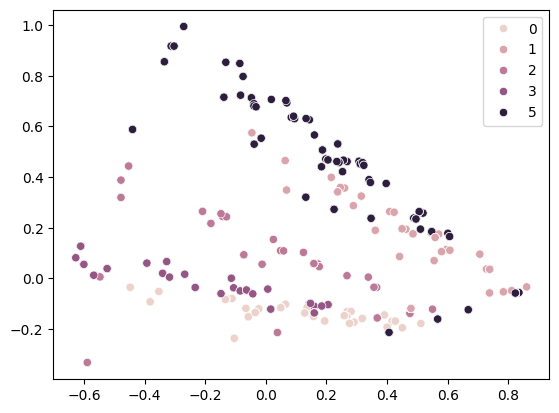

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
we_reduced = pca.fit_transform(weighted_embeddings)

sns.scatterplot(x=we_reduced[:, 0], y=we_reduced[:, 1], hue=symbols)

In [18]:
we_reduced.shape

(13688, 2)

In [19]:
we_reduced

array([[-0.10444204, -0.23631789],
       [ 0.47867057, -0.1185215 ],
       [ 0.0379504 , -0.21351559],
       ...,
       [ 0.15834798,  0.05863147],
       [ 0.00619592, -0.04213179],
       [ 0.23424687,  0.46133876]])

<Axes: >

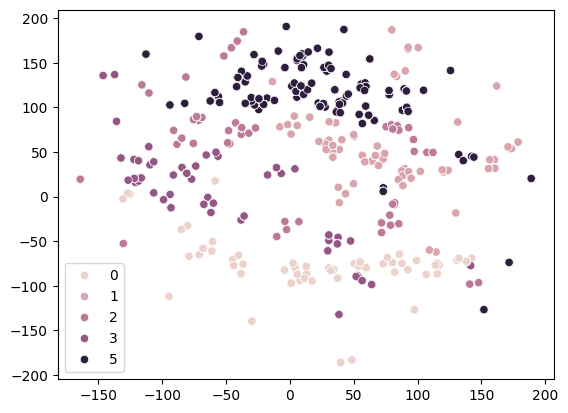

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE()
we_reduced = tsne.fit_transform(weighted_embeddings)

sns.scatterplot(x=we_reduced[:, 0], y=we_reduced[:, 1], hue=symbols)

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(5)
pred = kmeans.fit_predict(weighted_embeddings)

pred[:4]

/home/robert/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([4, 1, 0, 0], dtype=int32)

In [28]:
np.where(pred==0)[:5]

(array([    2,     3,     4, ..., 13683, 13685, 13686]),)

In [29]:
np.unique(symbols[np.where(pred==0)], return_counts=True), 

((array([0, 2, 3]), array([ 818,  927, 1183])),)

In [30]:
np.unique(symbols[np.where(pred==2)], return_counts=True)

(array([0, 2, 3]), array([ 188, 1600, 1710]))

In [31]:
np.unique(symbols[np.where(pred==3)], return_counts=True)

(array([1, 2, 5]), array([ 304,  143, 1409]))

In [32]:
src_embeddings[np.where(symbols==0)]

array([[-1.5022129,  0.7481862,  0.432684 ],
       [-1.5022129,  0.7481862,  0.432684 ],
       [-1.5022129,  0.7481862,  0.432684 ],
       ...,
       [-1.5022129,  0.7481862,  0.432684 ],
       [-1.5022129,  0.7481862,  0.432684 ],
       [-1.5022129,  0.7481862,  0.432684 ]], dtype=float32)